# COGS 108 - Capstone Project

## Project links, files, and basic information

### Websites with datasets:
- San Diego Vehicle Stops:  https://data.sandiego.gov/datasets/police-vehicle-stops/
- Dan Diego Population Data:  http://www.city-data.com/city/San-Diego-California.html

### Websites of needed information:
- San Diego police service areas https://www.sandiego.gov/police/services/divisions (vehcle stop data only records the first two digits)
- San Diego zip code map: http://www.city-data.com/zipmaps/San-Diego-California.html

### Names of datasets
#### *Vehicle Stops*
- 'vehicle_stops_2017.csv'
- 'vehicle_stops_2016.csv'
- 'vehicle_stops_2015.csv'
- 'vehicle_stops_2014.csv'

#### *Vehicle Stops Details*
- 'vehicle_stops_search_details_2017.csv'
- 'vehicle_stops_search_details_2016.csv'
- 'vehicle_stops_search_details_2015.csv'
- 'vehicle_stops_search_details_2014.csv'

#### *Files needed to read Vehicle Stops information*
- Race Codes: 'vehicle_stops_race_codes.csv'    
- Title explanations for Vehicle Stops data: 'vehicle_stops_dictionary.csv'
- Title explanations for Vehicle Stops Details data: 'vehicle_stops_search_details_dictionary.csv'
- Possible actions taken when stopped for Vehicle Stops Details data: 'vehicle_stops_search_details_description_list.csv'

In [2]:
# Imports
%matplotlib inline

# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Web scrapping
import sys
!conda install --yes --prefix {sys.prefix} beautifulsoup4

# Data analysis
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

import requests
import PyPDF2 as pdf
#import urllib2

Solving environment: ...working... done

# All requested packages already installed.



C:\Users\Gordee\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
df_stops = pd.read_csv('vehicle_stops_2017.csv')
df_stops_info = pd.read_csv('vehicle_stops_search_details_2017.csv')

In [17]:
print(df_stops_info.shape)

(31659, 6)


In [18]:
# The races that make up the majority of the san diego area
races = list(['W', 'H', 'A', 'B', 'I', 'O'])

### Pulls population chart from the PDF

In [111]:
################# function to get population data from a specific zip code ######################
import os
import PyPDF2 as pdf
import locale

def get_zip_info(code, percent):
    locale.setlocale(locale.LC_ALL, '')
    currDir = 'zip_pop_data\\'
    try:
        file = currDir + code + '.pdf'
        fpdf = pdf.PdfFileReader(file)
        page = fpdf.getPage(0).extractText()

        # Gets the beginning and end of the data we want
        index = page.find('Population\nPercent\nTotal Population')
        indexEnd = page.find('Source: SANDAG, Current Estimates (2010)\nPopulation by Race')
        text = page[index+19:indexEnd-1]
        text = list(text)
        for index, item in enumerate(text):
            if item == "\n":
                text[index] = '/'

        text = ''.join(text)
        text = text.split('/')
        groups = list()
        percentages = list()
        populations = list()
        cols = ['Group', 'Population', 'Percent']

        for item in text:
            if '%' in item:
                percentages.append(item)
            elif item[0].isnumeric():
                populations.append(locale.atoi(item) * np.float(percent))
            else:
                groups.append(item) 

        p_df = pd.DataFrame(columns = cols)
        p_df['Group'] = groups
        p_df['Population'] = populations
        p_df['Percent'] = percentages
        p_df.set_index('Group', inplace=True)
        p_df = p_df.reindex(["Total Population", "White", "Hispanic", "Asian", "Black", "Two or More", "American Indian",
                    "Pacific Islander", "Other"])
        p_df.fillna(0.0, inplace=True)
        
        # Makes sure that each value in percent column has a % sign on it - fixes errors caused by null
        
        for index, row in p_df.iterrows():
            if '%' not in str(row['Percent']):
                p_df.loc[index, 'Percent'] = str(row['Percent']) + '%'
        return p_df
    except PermissionError:
        print('error')


In [20]:
### DELETE BEFORE TURNIN ###
import os

currDir = 'zip_pop_data\\'
for currZip in os.listdir('zip_pop_data'):  
    try:
        file = os.fsdecode(currZip)
        fpdf = pdf.PdfFileReader(currDir + file)
        page = fpdf.getPage(0).extractText()

        # Gets the beginning and end of the data we want
        index = page.find('Population\nPercent\nTotal Population')
        indexEnd = page.find('Source: SANDAG, Current Estimates (2010)\nPopulation by Race')
        text = page[index+19:indexEnd-1]
        text = list(text)
        for index, item in enumerate(text):
            if item == "\n":
                text[index] = '/'

        text = ''.join(text)
        text = text.split('/')
        groups = list()
        percentages = list()
        populations = list()
        cols = ['Group', 'Population', 'Percent']

        for item in text:
            if '%' in item:
                percentages.append(item)
            elif item[0].isnumeric():
                populations.append(item)
            else:
                groups.append(item) 


        p_df = pd.DataFrame(columns = cols)
        p_df['Group'] = groups
        p_df['Population'] = populations
        p_df['Percent'] = percentages
        print(file)
        print(p_df)
        print('\n')
    except PermissionError:
        continue

### Cleaning stops dataframe - fuctions
    ### Clean unwanted columns

In [21]:
# Wanted column titles for stops dataframe
stops_col_titles = ['stop_id','stop_cause','service_area','subject_race','subject_sex','subject_age',
                    'arrested','searched','contraband_found','property_seized']

In [22]:
# Funtion to get rid of unwanted columns in vehicle stop dataset - Alberto
# Params: stops - dataset of stops to clean
def clean_stops_cols(stops):
    
    #Obtain unwated columns and drop them
    drop_list = np.setdiff1d(list(stops),stops_col_titles)
    stops.drop(drop_list, axis=1, inplace=True)
    
    return stops

Clean NaNs and missing values

In [23]:
#If nans exist of these columns the entry will be dropped
clean_nans_cols = ['stop_cause', 'stop_id', 'subject_race', 'subject_sex', 'subject_age']

In [24]:
# Funtion to get rid of nans vehicle stop dataset - Alberto
# Params: stops - dataset of stops to clean
def clean_stops_nans(stops):
    
    # Here we assume a Nan means a No in these columns (Since the majority of columns had 'Nan' instead of 'N')
    stops['arrested'] = stops['arrested'].replace({np.nan:'N'})
    stops['searched'] = stops['searched'].replace({np.nan:'N'})
    stops['contraband_found'] = stops['contraband_found'].replace({np.nan:'N'})
    stops['property_seized'] = stops['property_seized'].replace({np.nan:'N'})
    
    stops.dropna(how = 'any', subset = clean_nans_cols, inplace = True)
    
    return stops

### Cleaning stops detail dataframe - functions
    Clean unwanted columns of stop details dataset

In [25]:
# Wanted column titles for stops information dataframe
stops_info_col_titles = ['stop_id','search_details_type','search_details_description']

In [26]:
# Funtion to get rid of unwanted columns in vehicle stop informationdataset - Alberto
# Params: stops_info - dataset of stops information to clean
def clean_stops_info_cols(stops_info):
    
    #Obtain unwated columns and drop them
    drop_list = np.setdiff1d(list(stops_info),stops_info_col_titles)
    stops_info.drop(drop_list, axis=1, inplace=True) 
    
    return stops_info

Clean NaNs and missing values

In [27]:

# Take out meaningless entry
# Params: stops_info - dataset of stops information to clean
def clean_stops_info_meaningless(stops_info):
    
    stops_info = stops_info[~((stops_info['search_details_type'] == 'ActionTakenOther') 
                                      & stops_info['search_details_description'].isnull())]
    stops_info = stops_info[~((stops_info['search_details_type'] == 'ActionTaken') 
                                      & (stops_info['search_details_description'] == 'Other'))]
    stops_info = stops_info[~((stops_info['search_details_type'] == 'SearchBasis') 
                                      & (stops_info['search_details_description'] == 'Other'))]
    return stops_info

In [28]:
# Standarize action type entry
# Params: action - string to be standarized
def standardize_action_type(action_type):
    action_type = str(action_type)
    action_type = action_type.lower()
    
    if 'action' in action_type:
        action_type = 'action'
    
    elif 'search' in action_type:
        action_type = 'search'
        
    return action_type

In [29]:
# Standarize action details entry
# Params: action - string to be standarized
def standardize_action_desc(action):
    
    # Otherwise move onto parsinf
    action = str(action)
    action = action.lower()

    if 'nan' in action:
        #action = np.nan
        action = 'Other'
        
    elif 'arrest' in action:
        action = ['arrest']
        
    elif '310' in action:
        action = ['310']
        
    elif 'imp' in action:
        action = ['impound']

    elif 'tow' in action:
        action = ['tow']
        
    elif 'mistake' in action:
        action = ['released']
        
    elif 'released' in action:
        action = ['released']
        
    elif 'leave' in action:
        action = ['released']
        
    elif 'free' in action:
        action = ['released']
        
    elif 'no vio' in action:
        action = ['released']
        
    elif 'no dui' in action:
        action = ['released']
        
    elif 'nothing' in action:
        action = ['released']
         
    elif 'notice' in action:
        action = ['suspension notice']
        
    elif 'plate' in action:
        action = ['check plate']
        
    elif 'passenger' in action:
        action = ['passenger']
        
    elif 'license' in action:
        action = ['license']
        
    elif 'dui' in action:
        action = ['dui eval']
        
    elif 'det' in action:
        action = ['detention']
        
    elif 'contact' in action:
        action = ['contact']
        
    elif 'suspen' in action:
        action = ['suspension']
    
    elif 'susp' in action:
        action = ['suspect']
        
    elif 'cit' in action:
        action = ['citation']
        
    elif 'dmv' in action:
        action = ['DMV issue']
        
    else:
        action = 'Other'
        
    return action

In [30]:
# Clean nans and reduce descriptions
# Params: stops_info - dataset of stops information to clean
def clean_stops_info_nans(stops_info):
    
    # Clean meaningless columns
    stops_info = clean_stops_info_meaningless(stops_info)
    
    # Clean type column
    type_title = 'search_details_type'
    stops_info[type_title] = stops_info[type_title].apply(standardize_action_type)
    
    # Clean details column
    desc_title = 'search_details_description'
    stops_info[desc_title] = stops_info[desc_title].apply(standardize_action_desc)
    
    # Remove 'Other' and nan entries as they do not give us any extra information
    stops_info = stops_info[~(stops_info['search_details_description'] == "Other")]
    stops_info.dropna(how = 'any', subset = stops_info_col_titles, inplace = True)
    
    return stops_info

### Final cleaning functions

In [31]:
# Combine cleaning dataframe functions into one
# Params: stops - stops dataframe to be cleaned
def clean_stops(stops):
    stops = clean_stops_cols(stops)
    stops = clean_stops_nans(stops)
    
    return stops

In [32]:
# Combine cleaning dataframe functions into one
# Params: stops_info - stops information dataframe to be cleaned
def clean_stops_info(stops_info):
    stops_info = clean_stops_info_cols(stops_info)
    stops_info = clean_stops_info_nans(stops_info)
    return stops_info

In [118]:
# Read in 2017 datasets
df_stops_17 = pd.read_csv('vehicle_stops_2017.csv')
df_stops_16 = pd.read_csv('vehicle_stops_2016.csv')
df_stops_15 = pd.read_csv('vehicle_stops_2015.csv')
df_stops_14 = pd.read_csv('vehicle_stops_2014.csv')

df_stops_17 = clean_stops(df_stops_17)
df_stops_16 = clean_stops(df_stops_16)
df_stops_15 = clean_stops(df_stops_15)
df_stops_14 = clean_stops(df_stops_14)

In [119]:
# Read in 2017 datasets
df_stops_info_17 = pd.read_csv('vehicle_stops_search_details_2017.csv')
df_stops_info_16 = pd.read_csv('vehicle_stops_search_details_2016.csv')
df_stops_info_15 = pd.read_csv('vehicle_stops_search_details_2015.csv')
df_stops_info_14 = pd.read_csv('vehicle_stops_search_details_2014.csv')

df_stops_info_17 = clean_stops_info(df_stops_info_17)
df_stops_info_16 = clean_stops_info(df_stops_info_16)
df_stops_info_15 = clean_stops_info(df_stops_info_15)
df_stops_info_14 = clean_stops_info(df_stops_info_14)

## Merging the stops and details dataset

In [35]:
# Helper function: Merges duplicates within the information dataser
# Params: info - dataframe with stops information
def merge_duplicates(info):
    
    deleted = 0
    last_index = len(info) -1

    for index, row in info.iterrows():
    
        if deleted > 0:
            deleted -= 1
        
        elif index < last_index:
        
            s_id = row['stop_id']
        
            next_index = index+1
            next_id = info['stop_id'][next_index]
    
            while (s_id == next_id) & (next_index <= last_index):
            
                # Grab entry of duplicate
                entry = info.loc[next_index, 'search_details_description']
            
                # Append duplicate entry to original
                info.loc[index, 'search_details_description'].append(entry[0])
            
                # Drop duplicate row
                info.drop(next_index, inplace=True)
            
                # Increase index of next row
                next_index += 1
            
                # Check for out of bounds
                if next_index  < last_index:
                    next_id = info['stop_id'][next_index]
                
                deleted += 1
    return info

In [115]:
# Function: Merge the stops and details dataframes
# Params: stops - dataframe with stops information
#          info - dataframe with stop details
def merge_dataframes(stops, info):
    
    
    # Drop type information
    info.drop('search_details_type', axis=1, inplace=True)
    
    # Reset indeces
    info = info.reset_index()
    info.drop('index', axis=1, inplace=True)
    
    # Merge duplicates of information dataset
    info = merge_duplicates(info)
    
    df_merged = stops.merge(info, on = ['stop_id'], how = 'left')
    
    return df_merged

In [120]:
years = {
    '2017': merge_dataframes(df_stops_17, df_stops_info_17),
    '2016': merge_dataframes(df_stops_16, df_stops_info_16),
    '2015': merge_dataframes(df_stops_15, df_stops_info_15),
    '2014': merge_dataframes(df_stops_14, df_stops_info_14)
}

In [38]:
#df_merged = merge_dataframes(df_stops_17, df_stops_info_17)

In [138]:
years['2017'].head(30)

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,arrested,searched,contraband_found,property_seized,search_details_description
0,1444799,Moving Violation,120,I,M,37,N,N,N,N,[citation]
1,1444821,Equipment Violation,520,W,M,22,N,N,N,N,NaN
2,1447102,Moving Violation,520,W,M,29,N,N,N,N,[citation]
3,1444801,Equipment Violation,720,H,F,61,N,N,N,N,NaN
4,1444802,Equipment Violation,120,H,M,24,N,N,N,N,NaN
5,1444912,Equipment Violation,440,B,M,45,N,N,N,N,NaN
6,1444804,Moving Violation,520,H,M,45,N,N,N,N,NaN
7,1444805,Equipment Violation,520,H,M,38,N,N,N,N,[310]
8,1444807,Equipment Violation,510,H,M,30,N,N,N,N,NaN
9,1444811,Equipment Violation,310,B,M,54,N,Y,N,N,[citation]


In [40]:
# Maps all of the police race data into appropriate categories that
# the census gives us

def assign_race(race):
# A = asian, B = black, H = hispanic, I = indian, O = other
    race_dict = {}

    race_dict['A'] = 'A'
    race_dict['B'] = 'B'
    race_dict['C'] = 'A'
    race_dict['D'] = 'A'
    race_dict['F'] = 'A'
    race_dict['G'] = 'O'
    race_dict['H'] = 'H'
    race_dict['I'] = 'I'
    race_dict['J'] = 'A'
    race_dict['K'] = 'A'
    race_dict['L'] = 'O' #A?
    race_dict['O'] = 'O'
   # race_dict['P'] = 'P'
    race_dict['P'] = 'O'
    race_dict['S'] = 'O' #P?
    race_dict['U'] = 'O' #P?
    race_dict['V'] = 'A'
    race_dict['W'] = 'W'
    #race_dict['Z'] = 'T'
    race_dict['Z'] = 'O'

    race_dict['X'] = 'O'
    
    return race_dict[race]

In [134]:
years['2017']

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,arrested,searched,contraband_found,property_seized,search_details_description
0,1444799,Moving Violation,120,I,M,37,N,N,N,N,[citation]
1,1444821,Equipment Violation,520,W,M,22,N,N,N,N,NaN
2,1447102,Moving Violation,520,W,M,29,N,N,N,N,[citation]
3,1444801,Equipment Violation,720,H,F,61,N,N,N,N,NaN
4,1444802,Equipment Violation,120,H,M,24,N,N,N,N,NaN
5,1444912,Equipment Violation,440,B,M,45,N,N,N,N,NaN
6,1444804,Moving Violation,520,H,M,45,N,N,N,N,NaN
7,1444805,Equipment Violation,520,H,M,38,N,N,N,N,[310]
8,1444807,Equipment Violation,510,H,M,30,N,N,N,N,NaN
9,1444811,Equipment Violation,310,B,M,54,N,Y,N,N,[citation]


In [129]:
# Dictionary of all police areas
def get_year_areas():
    df_areas = {
        '110': [pd.DataFrame(), pd.DataFrame()],
        '120': [pd.DataFrame(), pd.DataFrame()],
        '130': [pd.DataFrame(), pd.DataFrame()],
        '230': [pd.DataFrame(), pd.DataFrame()],
        '240': [pd.DataFrame(), pd.DataFrame()],
        '310': [pd.DataFrame(), pd.DataFrame()],
        '320': [pd.DataFrame(), pd.DataFrame()],
        '430': [pd.DataFrame(), pd.DataFrame()],
        '440': [pd.DataFrame(), pd.DataFrame()],
        '510': [pd.DataFrame(), pd.DataFrame()],
        '520': [pd.DataFrame(), pd.DataFrame()],
        '530': [pd.DataFrame(), pd.DataFrame()],
        '610': [pd.DataFrame(), pd.DataFrame()],
        '620': [pd.DataFrame(), pd.DataFrame()],
        '630': [pd.DataFrame(), pd.DataFrame()],
        '710': [pd.DataFrame(), pd.DataFrame()],
        '720': [pd.DataFrame(), pd.DataFrame()],
        '810': [pd.DataFrame(), pd.DataFrame()],
        '820': [pd.DataFrame(), pd.DataFrame()],
        '830': [pd.DataFrame(), pd.DataFrame()],
        '840': [pd.DataFrame(), pd.DataFrame()],
        '930': [pd.DataFrame(), pd.DataFrame()],
        'Unknown': [pd.DataFrame(), pd.DataFrame()]
    }
    
    return df_areas

In [69]:
print(df_areas['110'][0])

Empty DataFrame
Columns: []
Index: []


### Counts the number of police actions for each race in each police area

In [146]:
def get_code_race_data(year, currArea):
    actions = list(['arrest', '310', 'impound', 'tow', 'released', 'suspension notice', 'check plate', 'passenger',
                   'license', 'dui eval', 'detention', 'contact', 'suspension', 'suspect', 'citation', 'DMV issue', 
                   'other', 'NaN', 'total'])

    cols = ['W', 'B', 'I', 'A', 'H', 'O']
    for df in currArea:
        currArea[df][0] = pd.DataFrame(columns = cols)
        currArea[df][0]['Action'] = actions
        currArea[df][0].fillna(0, inplace=True)
        currArea[df][0].set_index('Action', inplace=True)

    for index, row in years[year].iterrows():
        try:
            race = assign_race(row['subject_race'])
        except KeyError:
            continue
        desc = row['search_details_description']
        area = row['service_area']
        if desc is not np.nan:
            currArea[area][0].loc[desc, race] += 1
    for item in cols:
        for df in currArea:
            currArea[df][0].loc['total', item] = currArea[df][0][item].sum()

In [149]:
# Counts the total population for police area
# Since each police area covers multiple zip codes, we must loop through all codes in each area
def fill_area_pop_data(year, currArea):
    for area in currArea:
        codes = get_area_zips(area)
        if len(codes) is not 1:
            df_total = get_zip_info(codes[0], codes[1])
            for index in range(2,len(codes)-1, 2):
                df_temp = get_zip_info(codes[index], codes[index+1])
                df_total = df_total.add(df_temp, fill_value=0)

            for index, row in df_total.iterrows():
                # Calculates the new percentages of the added zip codes
                pop = int((row['Population'] / df_total['Population'][0] * 100))
                if pop == 0:
                    pop = '<1%'
                else:
                    pop = str(pop) + '%'
                df_total.loc[index, 'Percent'] = pop
                # Turning Populations into ints
                df_total.loc[index, 'Population'] = int(df_total.loc[index, 'Population'])

            currArea[area][1] = df_total
        else:
            continue

In [150]:
# Loads in all the data at once. Takes roughly 6 mins to run, but will make the rest of the program much faster 
df_2017 = get_year_areas()
df_2016 = get_year_areas()
df_2015 = get_year_areas()
df_2014 = get_year_areas()

get_code_race_data('2017', df_2017)
get_code_race_data('2016', df_2016)
get_code_race_data('2015', df_2015)
get_code_race_data('2014', df_2014)

fill_area_pop_data('2017', df_2017)
fill_area_pop_data('2016', df_2016)
fill_area_pop_data('2015', df_2015)
fill_area_pop_data('2014', df_2014)

In [104]:
# Function that maps zip codes to police areas
def get_area_zips(area):
    code_dict = {'110':list(['92122', '1', '92117', '1', '92111', '0.8', '92110', '0.4' ]),
                '120': list(['92109', '1', '92037', '1']),
                '130': list(['0']),
                '230': list(['92129', '1', '92128', '1', '92127', '0.3', '92025', '0.3']),
                '240': list(['92145', '1', '92126', '1', '92131', '1']),
                '310': list(['92123', '1', '92124', '1', '92108', '1', '92111', '0.2']),
                '320': list(['92120', '1', '92119', '1']),
                '430': list(['92139', '1', '92114', '1']),
                '440': list(['92136', '1', '92102', '0.4', '92113', '0.5']),
                '510': list(['92113', '0.5', '92102', '0.6']),
                '520': list(['92101', '1']),
                '530': list(['0']),
                '610': list(['92107', '1', '92106', '1', '92140', '1', '92110', '0.6']),
                '620': list(['92103', '1']),
                '630': list(['0']),
                '710': list(['92173', '1', '92154', '0.4']),
                '720': list(['92154', '0.6']),
                '810': list(['0']),
                '820': list(['92115', '1', '92116', '0.6']),
                '830': list(['92105', '0.8']),
                '840': list(['0']),
                '930': list(['92121', '1', '92130', '1', '92014', '1', '92091', '1', '92127', '0.7']),
                'Unknown': list(['0'])
                }
    return code_dict[area]


92122


In [154]:
df_years = {
    '2017':df_2017,
    '2016':df_2016,
    '2015':df_2015,
    '2014':df_2014
}

### Compares the number of actions taken against the given race vs. the population of that race

In [155]:
def race_compare(area, race, year):
    df_pop = df_areas[area][1]
    df_actions = df_years[year][area][0]
    switch = {
        'W': df_pop.loc['White', 'Population'] / df_actions.loc['total', race],
        'B': df_pop.loc['Black', 'Population'] / df_actions.loc['total', race],
        'I': df_pop.loc['American Indian', 'Population'] / df_actions.loc['total', race],
        'A': df_pop.loc['Asian', 'Population'] / df_actions.loc['total', race],
        'H': df_pop.loc['Hispanic', 'Population'] / df_actions.loc['total', race],
        'O': df_pop.loc['Other', 'Population'] / df_actions.loc['total', race],
    }
    
    return switch[race]

,Population,Percent
Group,,
Total Population,75557.0,100%
White,33587.0,44%
Hispanic,22134.0,29%
Asian,9039.0,11%
Black,7576.0,10%
Two or More,2486.0,3%
American Indian,236.0,<1%
Pacific Islander,277.0,<1%
Other,219.0,<1%


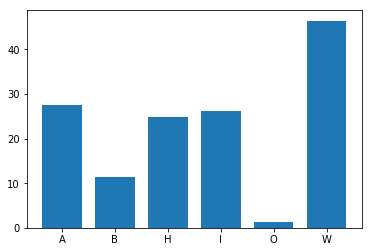

In [163]:
ratios = list()
for race in races:
    ratios.append(race_compare('820', race, '2014'))
fig = plt.figure()
plt.bar(races, ratios, width=.75)
df_years['2014']['820'][1]